In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
import seaborn as sns 
import matplotlib.pyplot as plt 

pd.set_option("display.max_rows", 10000, "display.max_columns", 10000)

sns.set(context='paper', 
        style='darkgrid', 
        rc={'figure.facecolor':'white'}, 
        font_scale=1.2)



In [2]:
def FormatTeams(df): 
    

    df['playoffs'] = df.Team.str.contains('\*', regex = True).astype('int') 
    
    df.Team = df.Team.str.strip().str.replace(' ', '_').str.lower().str.replace(
                '\*', '')

    
    return df

In [3]:
def ReadCSV(team_opponent): 
    
    df = pd.read_csv('csv_files/{}_stats.csv'.format(team_opponent),
                     index_col = 0).dropna(
    how = 'any').reset_index().drop(columns = ['G', 'MP'])
    
    df = df.drop(columns = ['index'])
    
    df = FormatTeams(df) 
    

    
    
    return df


team = ReadCSV('team') 
opponent = ReadCSV('opponent') 
opponent.head()

,Team,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,year,playoffs
0,san_antonio_spurs,35.2,82.7,0.425,4.3,12.6,0.343,30.8,70.1,0.440,15.6,21.0,0.739,12.0,29.4,41.4,20.3,7.9,5.2,14.4,23.1,90.2,2000,1
1,new_york_knicks,33.1,78.0,0.424,4.9,14.6,0.338,28.1,63.4,0.444,19.6,26.3,0.747,11.3,29.8,41.1,19.6,7.4,4.3,14.2,21.9,90.7,2000,1
2,portland_trail_blazers,34.5,80.0,0.431,4.8,14.6,0.330,29.6,65.4,0.453,17.3,24.2,0.716,11.9,27.1,39.0,20.8,8.0,4.3,14.5,22.8,91.0,2000,1
3,miami_heat,33.9,80.4,0.422,5.0,13.8,0.361,29.0,66.6,0.434,18.4,24.7,0.748,11.9,28.5,40.4,19.3,7.6,4.4,14.0,21.9,91.3,2000,1
4,utah_jazz,33.9,76.1,0.446,4.7,13.4,0.354,29.2,62.7,0.465,19.5,26.1,0.746,10.8,27.3,38.1,19.8,7.2,5.0,15.5,24.7,92.0,2000,1


In [4]:
## Normalize the data- normalize by year, then normalize by features 
from sklearn.preprocessing import MinMaxScaler

def Normalize(df): 
    df_group = df.drop(columns = ['playoffs'])
    df_group = df_group.groupby(['year'])
    df_group = df_group.transform(lambda x: (x - x.mean())/(x.std())) 
    #df_group = df_group.drop(columns = ['level_0', 'index'])
    df_group[df_group.columns] = MinMaxScaler().fit_transform(df_group) 
    
    df = pd.concat(
        [df[['Team', 'year']], df_group, df['playoffs']], axis = 1
    )
    
    return df

team = Normalize(team)
opponent = Normalize(opponent) 

In [5]:
from sklearn.model_selection import train_test_split 

def SplitDF(df): 
    x_cols =[col for col in team.columns if col not in ['playoffs', 'year', 'Team']]
    df_x = df[x_cols] 
    df_y = df.playoffs
    
    return train_test_split(df_x, df_y)

x_team_train, x_team_test, y_team_train, y_team_test = SplitDF(team) 
x_opponent_train, x_opponent_test, y_opponent_train, y_opponent_test = SplitDF(opponent) 


The offense playoff prediction accuracy is: 0.8280254777070064
The defense playoff prediction accuracy is: 0.8662420382165605


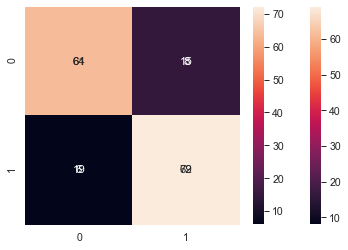

In [8]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix

def Accuracy(y_test, prediction): 
    score = accuracy_score(y_test, prediction) 
    
    confusion = confusion_matrix(y_test, prediction) 
    sns.heatmap(confusion, annot = True) 
    return score

def LogisticPrediction(x_train, y_train, x_test, y_test = None): 
    logistic_model = LogisticRegression(random_state = 1).fit(x_train, y_train) 

    prediction = logistic_model.predict(x_test) 
    if y_test is not None: 
        score = Accuracy(y_test, prediction) 
        
        return prediction, score 
    
    return prediction 


team_playoff_prediction, team_playoff_score = LogisticPrediction(x_team_train, 
                                                                y_team_train, 
                                                                x_team_test, 
                                                                y_team_test) 

opponent_playoff_prediction, opponent_playoff_score = LogisticPrediction(
    x_opponent_train, y_opponent_train,x_opponent_test, y_opponent_test) 


print('The offense playoff prediction accuracy is: {}'.format(team_playoff_score) )
print('The defense playoff prediction accuracy is: {}'.format(opponent_playoff_score)) 

The offense playoff prediction accuracy is: 0.8152866242038217
The defense playoff prediction accuracy is: 0.8535031847133758


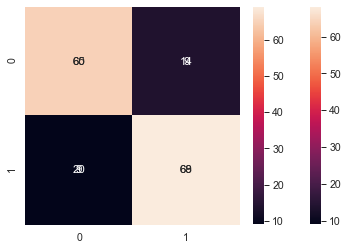

In [7]:
from xgboost import XGBClassifier


def RunXGBoost(x_train, y_train, x_test, y_test = None): 
    model = XGBClassifier(use_label_encoder = False, 
                         eval_metric = 'logloss') 
    model.fit(x_train, y_train) 
    
    prediction = model.predict(x_test) 
    
    if y_test is not None: 
        score = Accuracy(y_test, prediction) 
        return prediction, score 
    return prediction 


team_playoff_xg_prediction, team_playoff_xg_score = RunXGBoost(x_team_train, 
                                                                y_team_train, 
                                                                x_team_test, 
                                                                y_team_test) 

opponent_playoff_xg_prediction, opponent_playoff_xg_score = RunXGBoost(x_opponent_train, 
                                                                y_opponent_train, 
                                                                x_opponent_test, 
                                                                y_opponent_test) 

print('The offense playoff prediction accuracy is: {}'.format(team_playoff_xg_score) )
print('The defense playoff prediction accuracy is: {}'.format(opponent_playoff_xg_score)) 